In [1]:
import os 
import pandas as pd

In [2]:
os.listdir('../covid19-modelling-sg/data/statistics')

['active_number_under_quarantine.csv',
 'average_days_from_onset_to_isolation.csv',
 'case_status.csv',
 'daily_quarantine_orders_issued.csv',
 'epidemic_curve.csv',
 'epidemic_curve_of_community_cases.csv',
 'epidemic_split_curve.csv',
 'individuals_under_shn.csv',
 'shn_issued_by_press_release_date.csv',
 'swab_figures.csv',
 'total_cases_summed.csv']

In [3]:
fp = '../covid19-modelling-sg/data/statistics'

In [4]:
case_info = pd.read_csv(os.path.join(fp, 'epidemic_curve.csv'))
case_info = case_info.rename(columns={'Unnamed: 0':'Date'})
case_info['total_cases'] = case_info['Community Total Cases'] + case_info['Dormitory Residents Total Cases'] 

In [5]:
case_info['Date'] = pd.to_datetime(case_info['Date'])

In [6]:
case_info.head()

,Date,Community Total Cases,Dormitory Residents Total Cases,Imported Cases,total_cases
0,2020-01-23,0,0,1,0
1,2020-01-24,0,0,2,0
2,2020-01-25,0,0,1,0
3,2020-01-26,0,0,0,0
4,2020-01-27,0,0,1,0


In [7]:
current = pd.read_csv('../data/Covid-19 SG Clean.csv')

In [8]:
from sm_data import import_case_data

In [9]:
data_path = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_curve.csv')
lol = import_case_data(data_path, start_id=50, separate_dorms=True)

In [10]:
from sm_data import import_NPIS

NPI_PATH = 'data/NPIS_LC_processed.csv'
lol1 = import_NPIS(NPI_PATH, 50)

In [24]:
lol1[0].to_csv('data/NPIS_LC_processed.csv')

In [11]:
pd.to_datetime(lol1[1])

0     2020-01-23
1     2020-01-24
2     2020-01-25
3     2020-01-26
4     2020-01-27
         ...    
493   2021-05-30
494   2021-05-31
495   2021-06-01
496   2021-06-02
497   2021-06-03
Name: Date, Length: 498, dtype: datetime64[ns]

In [25]:
from sm_data import generate_prediction_data

a = generate_prediction_data(data_path, start_id=50,
                             end_date=-1, prediction_t=7, imported_case_extra='last',
                             separate_dorms=False)

Length training cases:  494
Length into model:  501   501


In [29]:
a[2]

501

# Test

In [2]:
import os

In [3]:
from sm_data import generate_prediction_data, generate_NPI_prediction_data
from covid.patients import get_delay_distribution, get_delays_from_patient_data, download_patient_data
from sm_utils import *
#from sm_utils import _get_convolution_ready_gt
data_path = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_curve.csv')
NPI_PATH1 = 'data/NPIS_LC_processed_V2.csv'
NPI_PATH2 = 'data/lockdown_index.csv'

# Load data
community_input, dorm_input, imported_input, total_input, len_obs = generate_prediction_data(data_path, start_id=50,
                             end_date=100, prediction_t=7, imported_case_extra='last',
                             separate_dorms=True)

# Load NPI Data
NPIS_array, date_ver = generate_NPI_prediction_data(NPI_PATH2, start_id=50, end_date=100, prediction_t=7)
print("NPIS Shape: ", NPIS_array.shape)

Length Community training cases:  100
Length Dorm training cases:  100
Length into model:  107   107   107
NPIS Shape:  (107, 1)


In [4]:
from sm_data import generate_ground_truth_forecast

com_gt, dorm_gt, import_gt, total_gt = generate_ground_truth_forecast(data_path, 50,
                             100, 7)

In [5]:
from sm_model import SemiMechanisticModels

In [6]:
sm_forecast = SemiMechanisticModels()
# Instatiate model based on data
sm_forecast.build_model(local_cases=community_input,
                          dorm_cases=dorm_input,
                          imported_cases=imported_input,
                          NPIS_array=NPIS_array,
                          len_observed=len_obs,
                          total_cases=None,
                          separate_dorms=True,
                          likelihood_fun='PO')

hi


/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_dorm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [7]:
sm_forecast.sample(chains=1, tune=50, draws=100, init_choice='adapt_diag')

/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [Seed_local, Seed_dorm, eps_t, log_eps_t, b_index, log_r_t_local, log_r_t_foreign]
>CompoundStep
>>Metropolis: [Obs_dorm_missing]
>>Metropolis: [Obs_local_missing]


Sampling 1 chain for 50 tune and 100 draw iterations (50 + 100 draws total) took 193 seconds.
/home/tzehong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (100) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Test Save

In [18]:
os.mkdir('Test_save')

In [19]:
save_fp = 'Test_save'
sm_forecast.save_sample(save_fp)

Saving to:  Test_save


FileExistsError: [Errno 17] File exists: 'Test_save'

Test Accuracy

In [11]:
trace_byious = sm_forecast._trace

In [13]:
trace_byious['diverging'].nonzero()[0].size

0

In [9]:
out = sm_forecast.get_accuracy(com_gt, dorm_gt, save=True, save_fp='lol.pkl')

In [10]:
out

{'dorm_train': (109.76212755773277, 75.3608),
 'local_train': (493.9279206716299, 383.9185),
 'dorm_test': (142.06922658639746, 127.86285714285715),
 'local_test': (4.485059324340888, 3.73)}

Plot Case Pred

In [9]:
"tester"

 EDA.ipynb			     generation_onsetdelay_time.txt
'Process NPIs.ipynb'		     lol.svg
 README.md			     lol1.png
'Semi-Mechanistic Models-V2.ipynb'   lol2.png
'Semi-Mechanistic Models.ipynb'      mlruns
 Untitled.ipynb			     notes.txt
'Vacination Rates.ipynb'	     sm_data.py
 __pycache__			     sm_env.yml
 anaylse_predictions.ipynb	     sm_model.py
 covid				     sm_run.py
 data				     sm_train.py
 epidemia_test.Rmd		     sm_utils.py
 generation_onsetdelay_time.py	     sm_validate.py


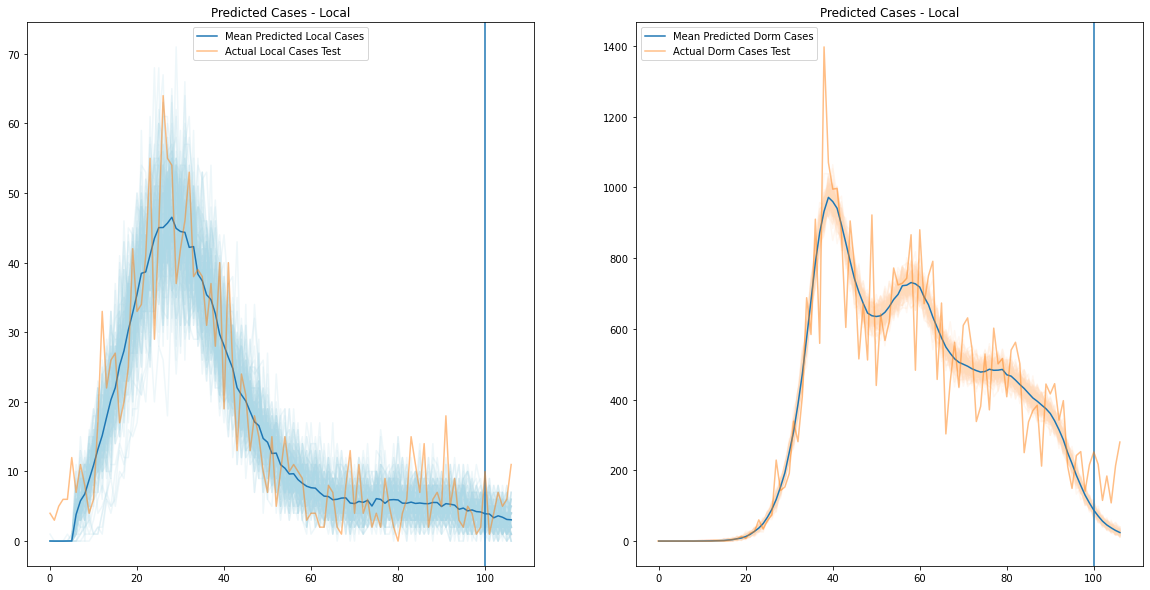

In [10]:
sm_forecast.plot_predictions(save=False,save_fp='lol.svg', actual_local_only=com_gt, actual_dorm_only=dorm_gt)

Plot Latent

In [22]:
"".join('asds@dsa'.split('@'))

'asdsdsa'

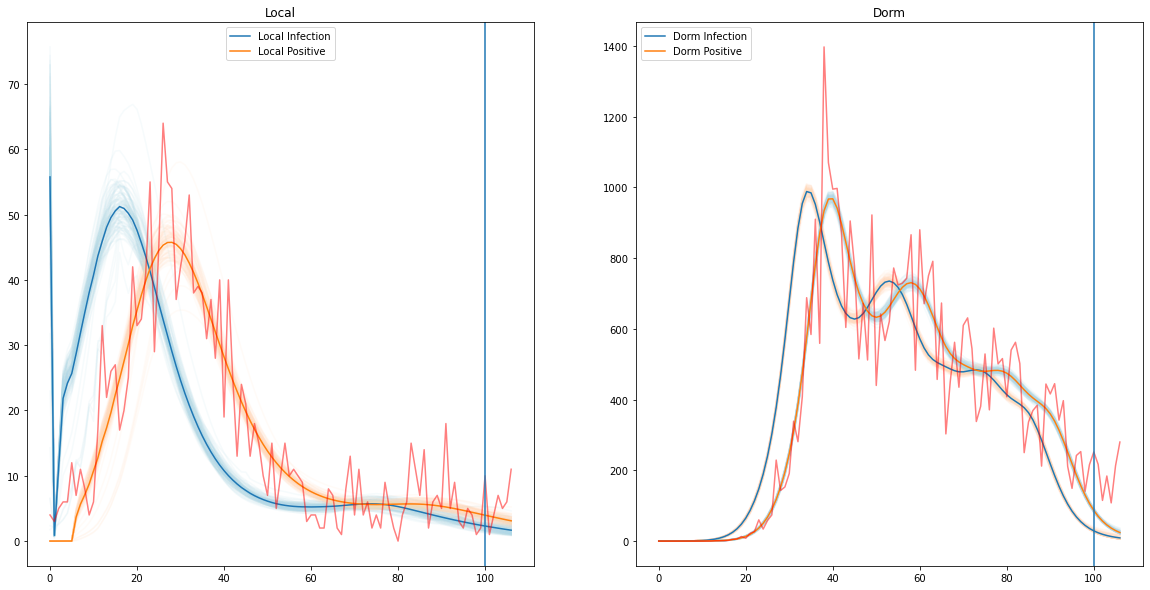

In [11]:
sm_forecast.plot_latents(save=True,save_fp='lol1.svg', actual_local_only=com_gt, actual_dorm_only=dorm_gt)

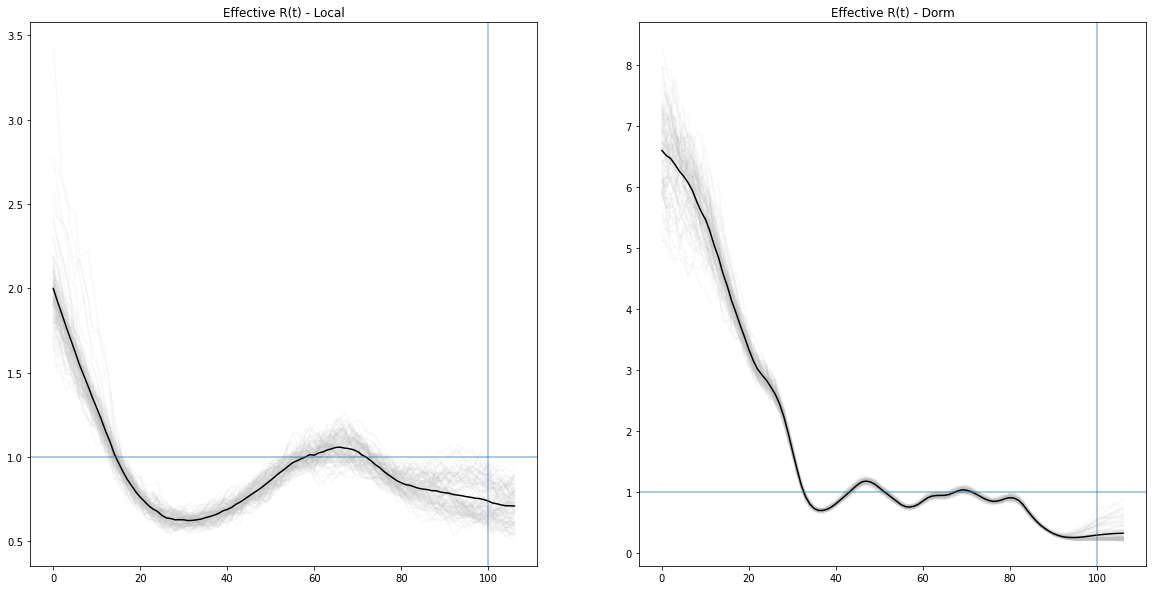

In [12]:
sm_forecast.plot_rt(save=True, save_fp='lol2.svg')

Get preds

In [13]:
sm_forecast.get_predictions()

(array([[4, 3, 1, 6, 1, 3, 6],
        [6, 4, 4, 3, 7, 3, 3],
        [7, 7, 5, 5, 6, 7, 2],
        [4, 5, 1, 1, 8, 4, 3],
        [3, 3, 5, 7, 3, 4, 2],
        [3, 8, 3, 8, 4, 2, 6],
        [3, 5, 3, 2, 5, 4, 5],
        [3, 4, 5, 6, 3, 3, 2],
        [3, 3, 5, 3, 3, 3, 0],
        [3, 5, 5, 3, 3, 2, 2],
        [6, 0, 4, 3, 3, 2, 4],
        [4, 1, 2, 0, 2, 3, 1],
        [4, 3, 5, 0, 3, 4, 1],
        [1, 2, 1, 3, 2, 4, 2],
        [3, 5, 1, 3, 2, 7, 0],
        [2, 2, 2, 1, 4, 4, 1],
        [2, 3, 2, 2, 3, 6, 5],
        [5, 4, 3, 4, 6, 6, 3],
        [5, 3, 2, 6, 1, 7, 2],
        [1, 4, 2, 4, 6, 2, 1],
        [5, 2, 7, 5, 3, 3, 4],
        [3, 0, 4, 4, 5, 3, 3],
        [2, 2, 5, 2, 6, 1, 1],
        [7, 1, 6, 6, 0, 4, 2],
        [3, 3, 6, 1, 3, 2, 0],
        [8, 3, 3, 1, 3, 1, 3],
        [4, 3, 3, 3, 4, 2, 0],
        [6, 3, 4, 4, 4, 6, 5],
        [3, 4, 1, 4, 2, 4, 3],
        [5, 5, 2, 6, 2, 5, 3],
        [5, 3, 3, 5, 1, 2, 5],
        [1, 2, 3, 6, 3, 1, 7],
        

In [18]:
import pymc3 as pm

In [19]:
with sm_forecast.model:
    ppc = pm.sample_posterior_predictive(model_trace)

In [429]:
ppc['Obs_local'].mean(0).shape

(502,)

In [433]:
np.sum(train_dorm_only_cases.isna())

7

In [22]:
train_dorm_only_cases = sm_forecast.dorm_cases
train_local_only_cases = sm_forecast.local_cases
end_date = 495

In [447]:
dorms_train = train_dorm_only_cases[:495]
dorms_pred_train = ppc['Obs_dorm'].mean(0)[:495]

In [449]:
np.mean(np.abs(dorms_train - dorms_pred_train))

22.103754783018697

In [24]:
import matplotlib.pyplot as plt

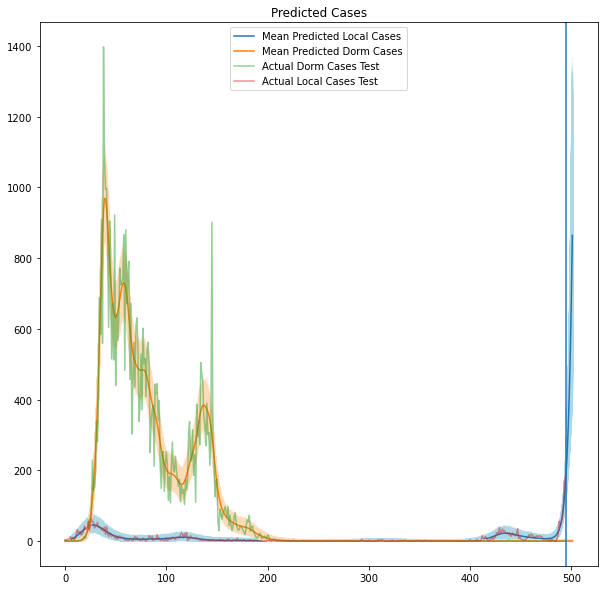

In [25]:
fig, ax = plt.subplots(figsize=(10,10))


#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax.plot(ppc['Obs_local'].T, c='lightblue', alpha=0.2)
ax.plot(ppc['Obs_local'].mean(0), alpha=1, label='Mean Predicted Local Cases')

ax.plot(ppc['Obs_dorm'].T, c='peachpuff', alpha=0.2)
ax.plot(ppc['Obs_dorm'].mean(0), alpha=1, label='Mean Predicted Dorm Cases')

# Actual cases
ax.axvline(x=end_date)
ax.plot(np.concatenate([train_dorm_only_cases]), alpha=0.5, label='Actual Dorm Cases Test')
ax.plot(np.concatenate([train_local_only_cases]), alpha=0.5, label='Actual Local Cases Test')

ax.legend()
ax.set_title("Predicted Cases")
plt.show()

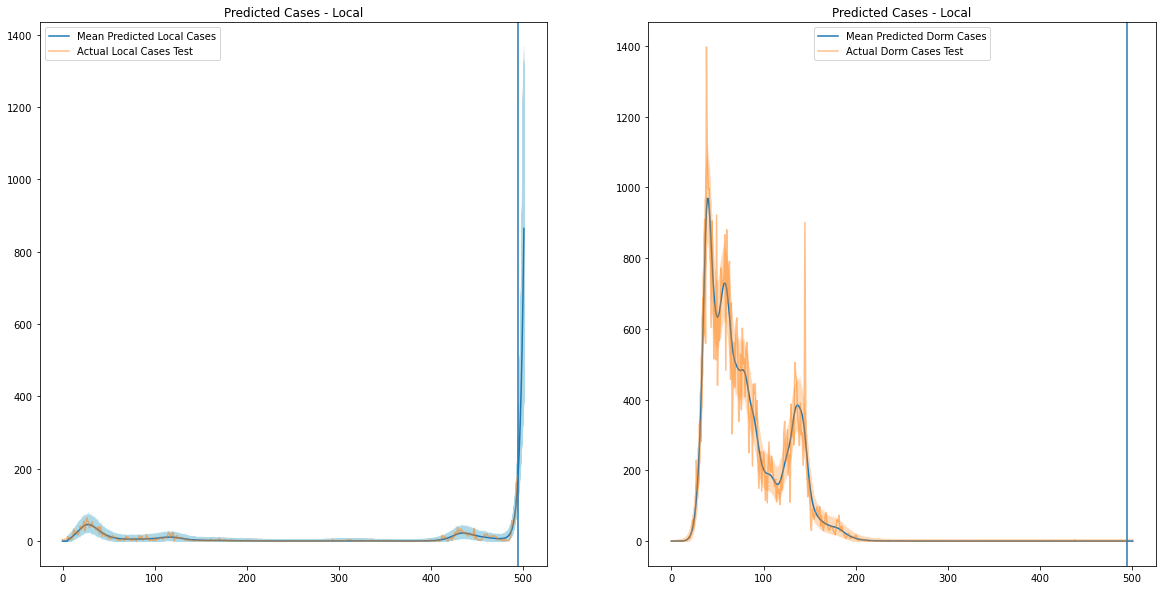

In [454]:
fig, ax = plt.subplots(1,2, figsize=(20,10))


#ax.plot(train_local_cases, c='b', label='Local Cases')
#ax.plot(temp_dates, trace_10['Obs_missing'].T, c='silver', alpha=0.2)
ax[0].plot(ppc['Obs_local'].T, c='lightblue', alpha=0.2)
ax[0].plot(ppc['Obs_local'].mean(0), alpha=1, label='Mean Predicted Local Cases')

ax[1].plot(ppc['Obs_dorm'].T, c='peachpuff', alpha=0.2)
ax[1].plot(ppc['Obs_dorm'].mean(0), alpha=1, label='Mean Predicted Dorm Cases')

# Actual cases
ax[0].axvline(x=end_date)
ax[1].axvline(x=end_date)

ax[0].plot(np.concatenate([train_local_only_cases]), alpha=0.5, label='Actual Local Cases Test')
ax[1].plot(np.concatenate([train_dorm_only_cases]), alpha=0.5, label='Actual Dorm Cases Test')

ax[0].legend()
ax[1].legend()

ax[0].set_title("Predicted Cases - Local")
ax[1].set_title("Predicted Cases - Local")
plt.show()

In [460]:
ppc['Obs_dorm'][:,495:].shape

(6684, 7)

In [455]:
np.concatenate([train_local_only_cases, None])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

Infected vs test positive

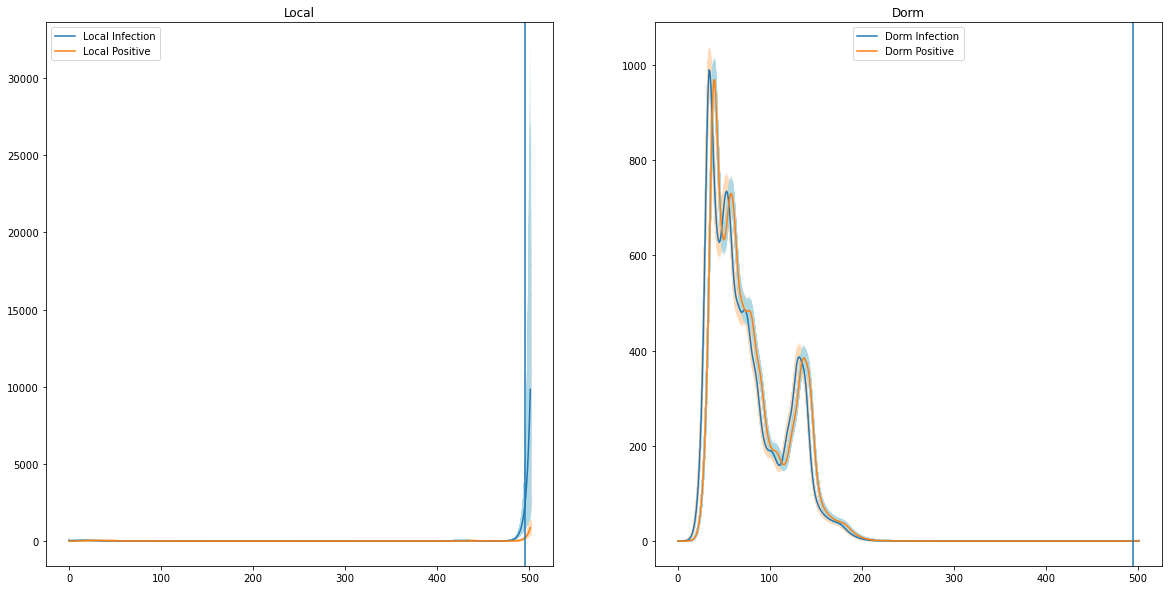

In [453]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(model_trace['infections_local'].T, c='lightblue', alpha=0.1)
ax[0].plot(model_trace['test_adjusted_positive_jit_local'].T, c='peachpuff', alpha=0.1)
ax[0].plot(model_trace['infections_local'].mean(0), label='Local Infection')
ax[0].plot(model_trace['test_adjusted_positive_jit_local'].mean(0), label='Local Positive')

ax[1].plot(model_trace['infections_dorm'].T, c='peachpuff', alpha=0.1)
ax[1].plot(model_trace['test_adjusted_positive_jit_dorm'].T, c='lightblue', alpha=0.1)
ax[1].plot(model_trace['infections_dorm'].mean(0), label='Dorm Infection')
ax[1].plot(model_trace['test_adjusted_positive_jit_dorm'].mean(0), label='Dorm Positive')


#ax[0].plot(np.concatenate([train_local_only_cases, actual_local_only]), c='r', alpha=0.5)
#ax[1].plot(np.concatenate([train_dorm_only_cases, actual_dorm_only]), c='r', alpha=0.5)
#ax.plot(imported_input, c='g')

ax[0].axvline(x=end_date)
ax[1].axvline(x=end_date)

ax[0].legend()
ax[1].legend()

ax[0].set_title('Local')
ax[1].set_title('Dorm')
plt.show()

In [28]:
ppc['Obs_local'].mean(0)[494:]

array([153.68372232, 198.61086176, 255.01855177, 327.54398564,
       417.60532615, 533.18237582, 679.70347098, 864.21080192])

In [29]:
end_date=495

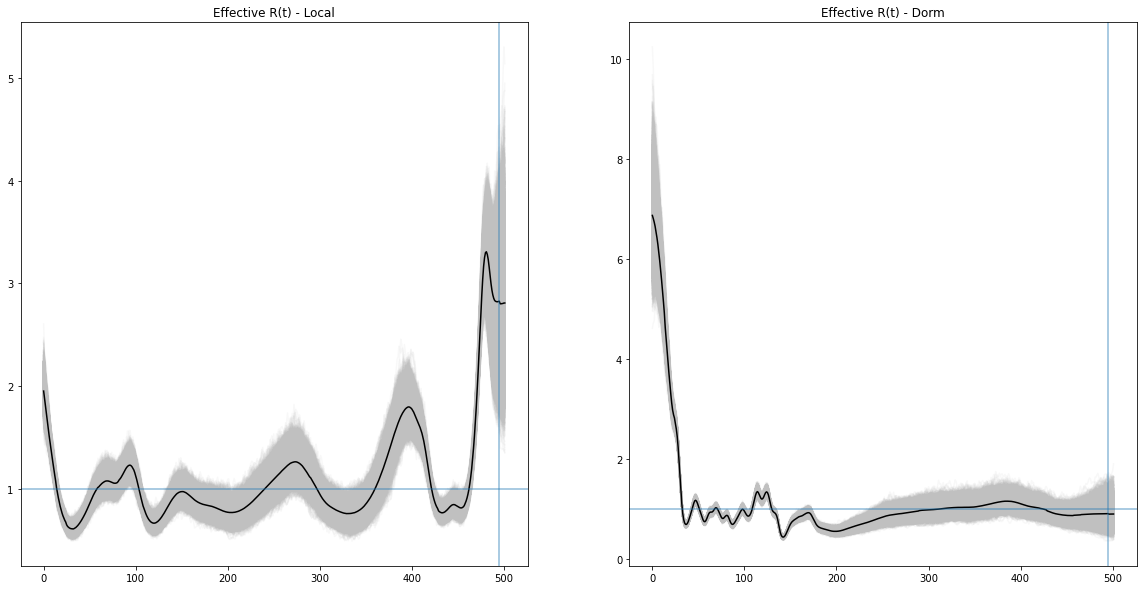

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(model_trace['r_t_local'].T, c='silver', alpha=0.1)
ax[0].plot(model_trace['r_t_local'].mean(0), c='black', alpha=1)
ax[0].axhline(y=1, alpha=0.5)
ax[0].axvline(x=end_date, alpha=0.5)
ax[0].set_title("Effective R(t) - Local")

ax[1].plot(model_trace['r_t_foreign'].T, c='silver', alpha=0.1)
ax[1].plot(model_trace['r_t_foreign'].mean(0), c='black', alpha=1)
ax[1].axhline(y=1, alpha=0.5)
ax[1].axvline(x=end_date, alpha=0.5)
ax[1].set_title("Effective R(t) - Dorm")

plt.show()